# Classifying Employee Churn

Imports

In [1]:
#Import data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Set the plotting style
sns.set()
#Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Load in the data

In [2]:
df = pd.read_csv('./data/clean_data.csv').drop("Unnamed: 0", axis=1)
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,departure
0,Operations,Not Promoted,0.577569,3,Low,5,0.626759,No Bonus,180.866070,Stayed
1,Operations,Not Promoted,0.751900,3,Medium,6,0.443679,No Bonus,182.708149,Stayed
2,Support,Not Promoted,0.722548,3,Medium,6,0.446823,No Bonus,184.416084,Stayed
3,Logistics,Not Promoted,0.675158,4,High,8,0.440139,No Bonus,188.707545,Stayed
4,Sales,Not Promoted,0.676203,3,High,5,0.577607,Bonus,179.821083,Stayed


## 1. Feature Engineering and Selection

### Feature Analysis
From the Turnover Analysis Notebook, we noticed that all features (excluding bonus and employee satisfaction) are good indicators of an employee leaving. As such, these features can be used as inputs to a classification model that predicts if an employee is likely to leave.
<br>Also, we noticed that the churn distributions varied significantly between the departments, so we will either create a prediction model for each department or include the department as an input feature to the model

Looking at the distributions of the features

In [3]:
print(len(df))
df.describe()

9540


,review,projects,tenure,satisfaction,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.651826,3.274843,6.556184,0.504645,184.661571
std,0.085307,0.579136,1.415432,0.158555,4.144831
min,0.310000,2.000000,2.000000,0.000000,171.374060
25%,0.592884,3.000000,5.000000,0.386801,181.472085
50%,0.647456,3.000000,7.000000,0.500786,184.628796
75%,0.708379,4.000000,8.000000,0.622607,187.728708
max,1.000000,5.000000,12.000000,1.000000,200.861656


As we can see, the range and mean of the numerical features vary significantly, so we will normalize the data for improved model performance.<br>Luckily, we can also see that there are no missing values, since the count is the same as the length of the data set.

In [4]:
def feat_eng(df):
    #Seperate the data into categorical and numeric data types
    df_cat = df.select_dtypes(include="object")
    df_num = df.select_dtypes(exclude="object")
    #Center the data around 0
    df_num -= df_num.mean()
    #Convert all variable's standard deviation to 1
    df_num /= df_num.std()

    return pd.concat([df_cat, df_num], axis=1)
df_eng = feat_eng(df)

In [5]:
df_eng.describe()

,review,projects,tenure,satisfaction,avg_hrs_month
count,9.540000e+03,9.540000e+03,9.540000e+03,9.540000e+03,9.540000e+03
mean,-8.820850e-15,4.835463e-16,-1.226487e-14,-4.824443e-15,1.271211e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.007024e+00,-2.201285e+00,-3.218936e+00,-3.182769e+00,-3.205803e+00
25%,-6.909480e-01,-4.745741e-01,-1.099441e+00,-7.432330e-01,-7.695094e-01
50%,-5.122694e-02,-4.745741e-01,3.135548e-01,-2.433809e-02,-7.907581e-03
75%,6.629284e-01,1.252137e+00,1.020053e+00,7.439815e-01,7.399909e-01
max,4.081431e+00,2.978848e+00,3.846046e+00,3.124184e+00,3.908503e+00


Next, we will need to one-hot encode the categorical variables

In [6]:
#Rename salary values for one-hot encoding
salary_one_hot = df.salary.apply(lambda x: x + " Salary")
df_eng.salary = salary_one_hot
cat_vars = ['promoted', 'salary', 'bonus']
#Get the one-hot encoding
one_hot = pd.get_dummies(df_eng[cat_vars], "", "")
#Replace categorical features with one-hot encoded features
df_one_hot = df_eng.drop(cat_vars, axis=1).join(one_hot)
df_one_hot.head()

,department,departure,review,projects,tenure,satisfaction,avg_hrs_month,Not Promoted,Promoted,High Salary,Low Salary,Medium Salary,Bonus,No Bonus
0,Operations,Stayed,-0.870478,-0.474574,-1.099441,0.770170,-0.915719,1,0,0,1,0,0,1
1,Operations,Stayed,1.173100,-0.474574,-0.392943,-0.384507,-0.471291,1,0,0,0,1,0,1
2,Support,Stayed,0.829033,-0.474574,-0.392943,-0.364676,-0.059227,1,0,0,0,1,0,1
3,Logistics,Stayed,0.273507,1.252137,1.020053,-0.406835,0.976149,1,0,1,0,0,0,1
4,Sales,Stayed,0.285755,-0.474574,-1.099441,0.460174,-1.167837,1,0,1,0,0,1,0


Next, we will want to drop features that are highly correlated, since having multiple features that trend the same way could skew the results towards those feautures

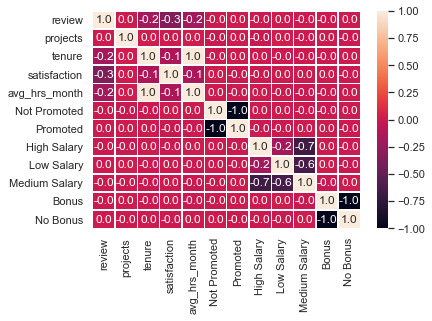

In [7]:
sns.heatmap(df_one_hot.corr(), annot=True,fmt='.1f', linewidth=0.5)
plt.show()

From the above correlation heatmap, we can see that tenure and average hours per month are highly correlated, so we will drop tenure from our features<br><br>We can also see a strong negative correlation between the categorical variables, but this is to be expected since one-hot encoding insures that the groups within a categorical feature are mutually exclusive

In [8]:
#Drop the highly correlated feature
df_one_hot.drop("tenure", axis=1, inplace=True)

## 2. Build the Classification Model

Imports

In [9]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

Split the data into training and testing data

Model 1: One-Hot encode the department feature

In [23]:
#Encode the department data
dep_one_hot = pd.get_dummies(df_one_hot.department, "", "")
model_data = df_one_hot.drop("department", axis=1).join(dep_one_hot)
#Split the data into training and testing data
features = model_data.drop("departure", axis=1)
targets = model_data.departure.apply(lambda x: 0 if x=="Stayed" else 1) #Replace target names with target numbers

train_feats, test_feats, train_trgts, test_trgts = train_test_split(features, targets, test_size=0.3)

Build the basic classifier model

In [24]:
churn_classifier = xgb.XGBClassifier(objective="binary:logistic").fit(train_feats, train_trgts)

[15:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Evaluate the performance of the model

Accuracy: 85.64%


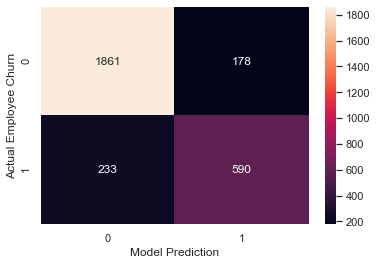

The model incorrectly predicts that an employee will churn 23.18% of the time


In [28]:
#Accuracy
model_predictions = churn_classifier.predict(test_feats)
accuracy = accuracy_score(test_trgts, model_predictions)
print(f"Accuracy: {round(accuracy*100, 2)}%")
#Confusion Matrix
CM = confusion_matrix(test_trgts, model_predictions)
sns.heatmap(CM, annot=True, fmt="d")
plt.xlabel("Model Prediction")
plt.ylabel("Actual Employee Churn")
plt.show()

incorrect_churn_prediction = CM[0,1]
total_churn_prediction = sum(CM[:,1])
churn_prediction_rate = incorrect_churn_prediction/total_churn_prediction*100
print(f"The model incorrectly predicts that an employee will churn {round(churn_prediction_rate, 2)}% of the time")

From the above confusion matrix, we can see that the model incorrectly predicts an employee will churn approximately 1 out of every 4 employees<br><br>
This is not a good prediction, so we will need to further tweak the parameters

Model 2: Department specific Models

In [15]:
department_model = {}
for department in df.department.unique():
    #Extract the department data
    dep_data = df_one_hot[df_one_hot.department == department].drop("department", axis=1)
    #Extract training and testing data
    features = dep_data.drop("departure", axis=1)
    targets = dep_data.departure.apply(lambda x: 0 if x=="Stayed" else 1) #Replace target names with target numbers

    features = dep_data.select_dtypes(exclude="object")
    targets = dep_data.departure.apply(lambda x: 0 if x=="Stayed" else 1) #Replace target names with target numbers

    train_feats, test_feats, train_trgts, test_trgts = train_test_split(features, targets, test_size=0.2)
    #Train the model
    classifier = xgb.XGBClassifier().fit(train_feats, train_trgts)
    #Append info to dictionary
    department_model[department] = {
        'model': classifier,
        'testing data': {
            "features": test_feats,
            "targets": test_trgts
        }
    }

[15:36:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Evaluate the performance of each department



Department: Operations
Accuracy: 81.97%


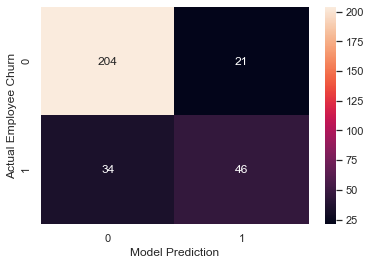

The model incorrectly predicts that an employee will churn 31.34% of the time


Department: Support
Accuracy: 84.35%


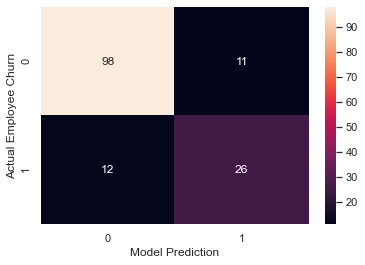

The model incorrectly predicts that an employee will churn 29.73% of the time


Department: Logistics
Accuracy: 70.83%


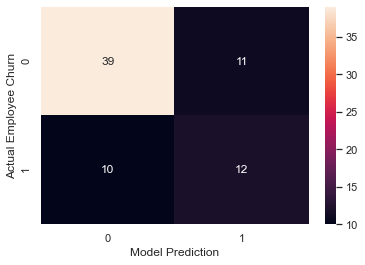

The model incorrectly predicts that an employee will churn 47.83% of the time


Department: Sales
Accuracy: 85.94%


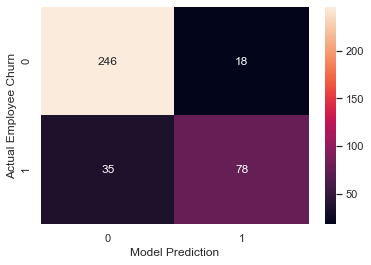

The model incorrectly predicts that an employee will churn 18.75% of the time


Department: IT
Accuracy: 86.11%


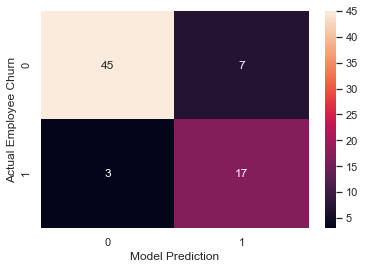

The model incorrectly predicts that an employee will churn 29.17% of the time


Department: Admin
Accuracy: 83.53%


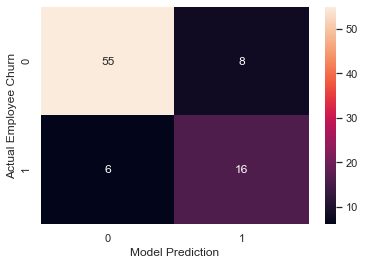

The model incorrectly predicts that an employee will churn 33.33% of the time


Department: Engineering
Accuracy: 85.2%


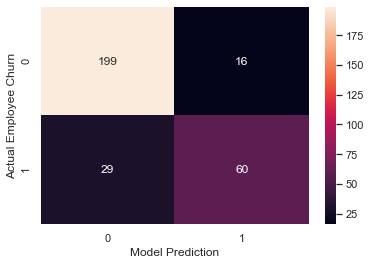

The model incorrectly predicts that an employee will churn 21.05% of the time


Department: Marketing
Accuracy: 83.23%


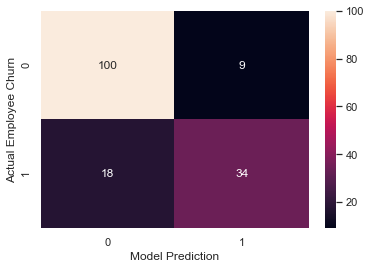

The model incorrectly predicts that an employee will churn 20.93% of the time


Department: Finance
Accuracy: 83.95%


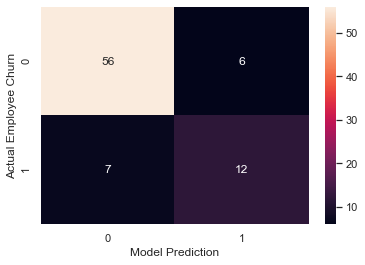

The model incorrectly predicts that an employee will churn 33.33% of the time


Department: Retail
Accuracy: 82.85%


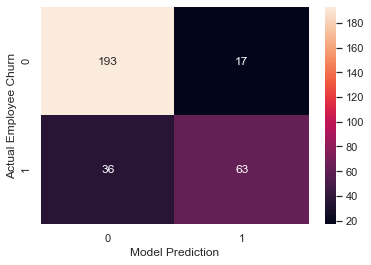

The model incorrectly predicts that an employee will churn 21.25% of the time


In [27]:
for department in df.department.unique():
    #Extract department info
    model = department_model[department]['model']
    test_data = department_model[department]['testing data']

    #Accuracy
    model_predictions = model.predict(test_data["features"])
    accuracy = accuracy_score(test_data["targets"], model_predictions)

    #Display the results
    print(f"\n\nDepartment: {department}")
    print("===============================================")
    print(f"Accuracy: {round(accuracy*100, 2)}%")
    #Confusion Matrix
    CM = confusion_matrix(test_data["targets"], model_predictions)
    sns.heatmap(CM, annot=True, fmt="d")
    plt.xlabel("Model Prediction")
    plt.ylabel("Actual Employee Churn")
    plt.show()

    incorrect_churn_prediction = CM[0,1]
    total_churn_prediction = sum(CM[:,1])
    churn_prediction_rate = incorrect_churn_prediction/total_churn_prediction*100
    print(f"The model incorrectly predicts that an employee will churn {round(churn_prediction_rate, 2)}% of the time")

It seems that training a model for each department didn't change the accuracy of the model, so we will revert back to the model that predicts for all departments and tweak it for better results.

confusion_matrix(test_data["targets"], model_predictions)

In [17]:
confusion_matrix(test_data["targets"], model_predictions)

array([[193,  17],
       [ 36,  63]], dtype=int64)